In [47]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [28]:
customers = pd.read_excel('/home/joao/code/capstone/data/Customers.xlsx')
orders = pd.read_excel('/home/joao/code/capstone/data/Orders.xlsx')

In [29]:
customers.head()

,Customer_ID,GENDER,AGE,GEOGRAPHY
0,2547,M,43,Greece
1,822,M,42,Spain
2,3686,F,39,France
3,3719,F,30,Italy
4,9200,F,31,Italy


In [30]:
orders.head()

,id,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,2021-01-02,2547,1,X52,0EM7L,1.0,3.13
1,2,2021-01-02,822,2,2ML,68BRQ,1.0,5.46
2,3,2021-01-02,3686,3,0H2,CZUZX,1.0,6.35
3,4,2021-01-02,3719,4,0H2,549KK,1.0,5.59
4,5,2021-01-02,9200,5,0H2,K8EHH,1.0,6.88


In [31]:
customers.dtypes

Customer_ID     int64
GENDER         object
AGE             int64
GEOGRAPHY      object
dtype: object

In [32]:
orders.dtypes

id                         int64
Date              datetime64[ns]
Customer_ID                int64
Transaction_ID             int64
SKU_Category              object
SKU                       object
Quantity                 float64
Sales_Amount             float64
dtype: object

### Cleaning the data

In [33]:
customers = customers.rename(columns={
    'Customer_ID':'customer_id',
    'GENDER':'gender',
    'AGE':'age',
    'GEOGRAPHY':'country'
})

In [34]:
customers.columns

Index(['customer_id', 'gender', 'age', 'country'], dtype='object')

In [35]:
orders = orders.rename(columns= {
    'Date':'date',
    'Customer_ID':'customer_id',
    'Transaction_ID':'transaction_id',
    'SKU_Category':'sku_category',
    'SKU':'sku',
    'Quantity':'quantity',
    'Sales_Amount':'sales_amount'
})

In [36]:
orders.columns

Index(['id', 'date', 'customer_id', 'transaction_id', 'sku_category', 'sku',
       'quantity', 'sales_amount'],
      dtype='object')

In [37]:
customers.isna().sum()

customer_id    0
gender         0
age            0
country        0
dtype: int64

In [38]:
orders.isna().sum()

id                0
date              0
customer_id       0
transaction_id    0
sku_category      0
sku               0
quantity          0
sales_amount      0
dtype: int64

In [39]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%M-%d')
orders['date'].head()

0   2021-01-02
1   2021-01-02
2   2021-01-02
3   2021-01-02
4   2021-01-02
Name: date, dtype: datetime64[ns]

In [42]:
# Merging the two DataFrames on 'customer_id'
merged_df = pd.merge(orders, customers, on='customer_id', how='inner')

# Display the first few rows of the merged DataFrame
merged_df.head()


,id,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
0,1,2021-01-02,2547,1,X52,0EM7L,1.0,3.13,M,43,Greece
1,639,2021-01-04,2547,332,Q4N,MM3E0,1.0,12.69,M,43,Greece
2,7800,2021-01-25,2547,3743,X52,885U7,1.0,4.95,M,43,Greece
3,7801,2021-01-25,2547,3743,29A,A59HR,3.0,6.24,M,43,Greece
4,17633,2021-02-22,2547,8477,L9F,7W8WS,1.0,11.75,M,43,Greece


In [43]:
merged_df.to_csv('merged_df.csv', index=False)

### EDA

In [44]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              131706 non-null  int64         
 1   date            131706 non-null  datetime64[ns]
 2   customer_id     131706 non-null  int64         
 3   transaction_id  131706 non-null  int64         
 4   sku_category    131706 non-null  object        
 5   sku             131706 non-null  object        
 6   quantity        131706 non-null  float64       
 7   sales_amount    131706 non-null  float64       
 8   gender          131706 non-null  object        
 9   age             131706 non-null  int64         
 10  country         131706 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 11.1+ MB


In [45]:
print("\nUnique values:")
print(merged_df.nunique().sort_values(ascending=False))


Unique values:
id                131706
transaction_id     64682
customer_id        22625
sku                 5242
sales_amount        3233
date                 362
sku_category         187
quantity              83
age                   45
country                7
gender                 2
dtype: int64


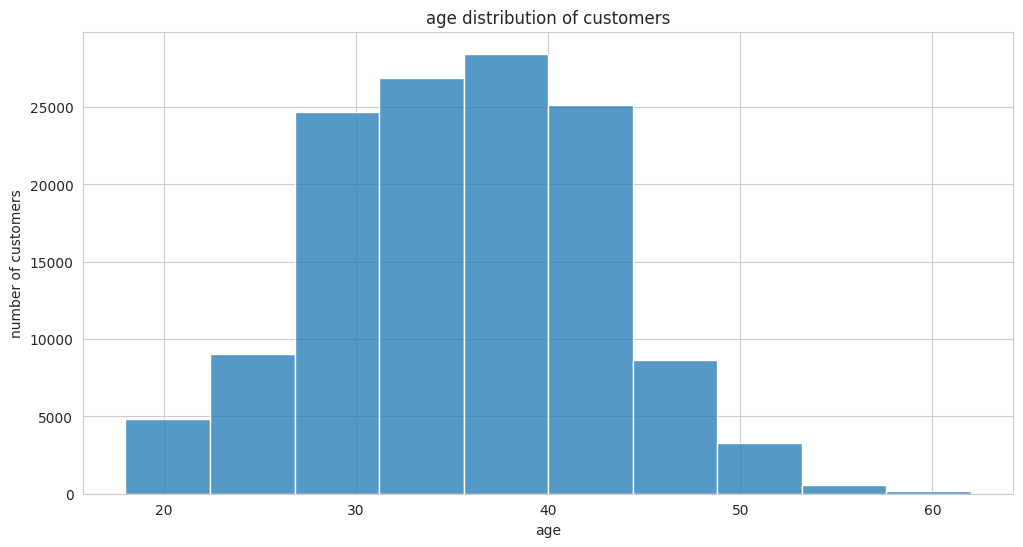

In [50]:
sns.set_style("whitegrid")

# Age Distribution
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['age'], bins=10, kde=False)
plt.title('age distribution of customers')
plt.xlabel('age')
plt.ylabel('number of customers')
plt.show()

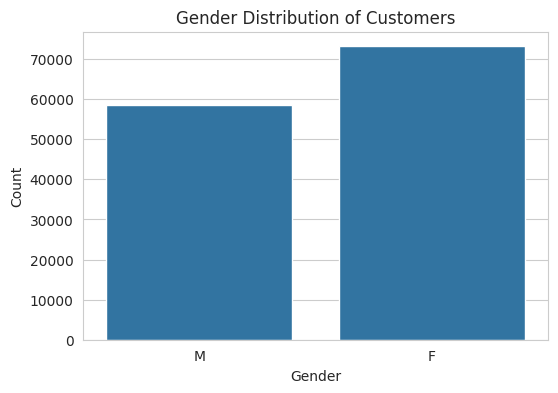

In [51]:
# Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=merged_df)
plt.title('Gender Distribution of Customers')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

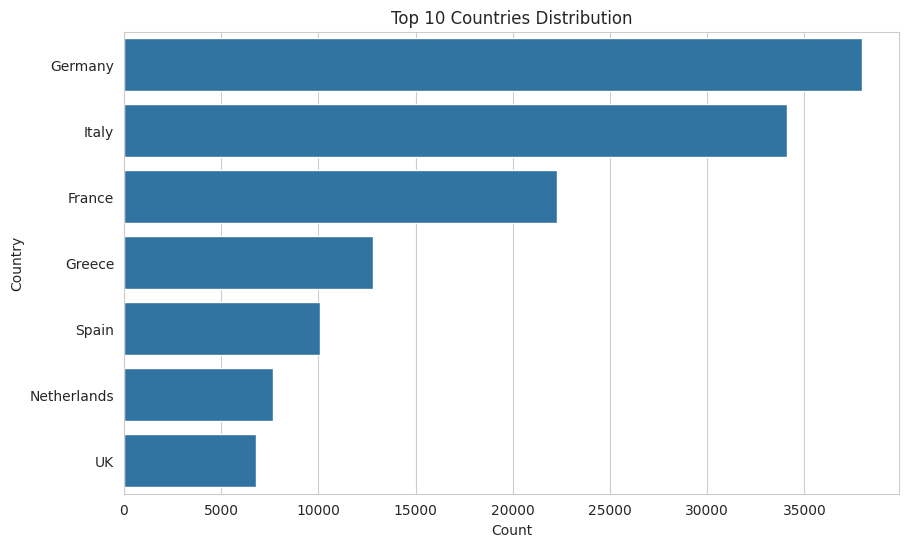

In [52]:
# Country Distribution
plt.figure(figsize=(10, 6))
country_counts = merged_df['country'].value_counts().head(10)  # Top 10 countries
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title('Top 10 Countries Distribution')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

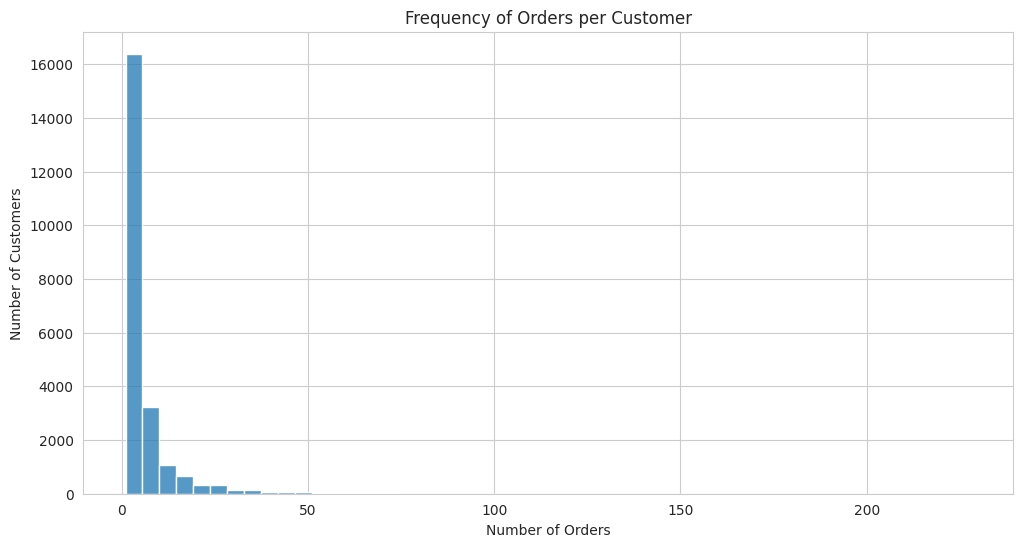

In [28]:
# Frequency of Orders per Customer
order_frequency = merged_df.groupby('customer_id')['id'].count()

plt.figure(figsize=(12, 6))
sns.histplot(order_frequency, bins=50, kde=False)
plt.title('Frequency of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()

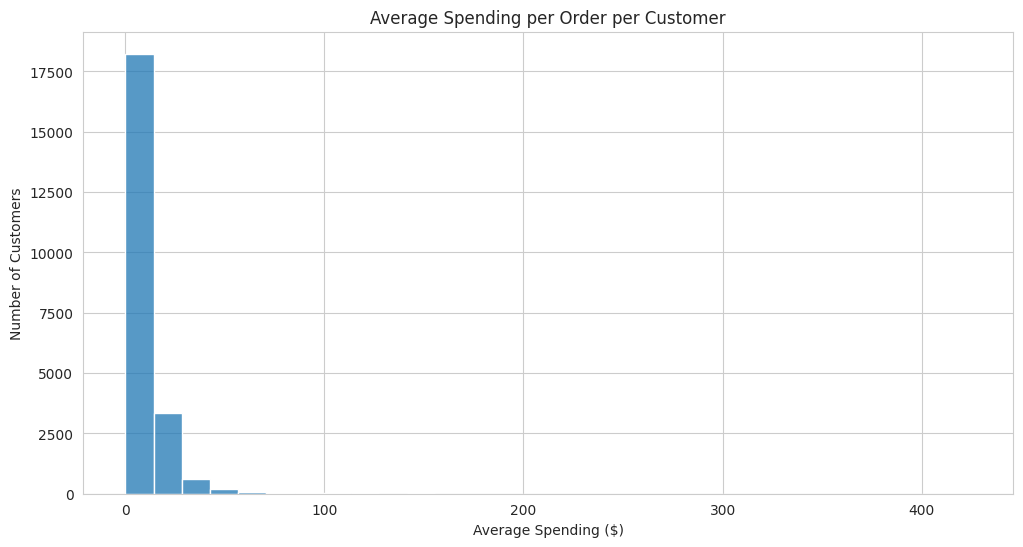

In [29]:
# Average Spending per Order
average_spending = merged_df.groupby('customer_id')['sales_amount'].mean()

plt.figure(figsize=(12, 6))
sns.histplot(average_spending, bins=30, kde=False)
plt.title('Average Spending per Order per Customer')
plt.xlabel('Average Spending ($)')
plt.ylabel('Number of Customers')
plt.show()

### Time series analysys

### Customer Segmentation

Recency (R): How recently a customer has made a purchase. We can calculate this by finding the number of days since a customer's last purchase.

Frequency (F): How often a customer makes a purchase. We can calculate this by counting the number of transactions each customer has made.

Monetary (M): How much money a customer has spent. We can calculate this by summing up the sales amount for each customer.


In [61]:
from datetime import datetime

# Find the most recent purchase date in the data to use as a reference point
most_recent_purchase = merged_df.index.max()

# Calculate Recency by finding how many days ago was the customer's last purchase
recency_df = merged_df.groupby('customer_id').apply(lambda x: (most_recent_purchase - x.index.max()).days).reset_index()
recency_df.columns = ['customer_id', 'recency']

# Calculate Frequency by counting how many times a customer made a purchase
frequency_df = merged_df.groupby('customer_id')['transaction_id'].nunique().reset_index()
frequency_df.columns = ['customer_id', 'frequency']

# Calculate Monetary by summing all sales amount for each customer
monetary_df = merged_df.groupby('customer_id')['sales_amount'].sum().reset_index()
monetary_df.columns = ['customer_id', 'monetary']

# Merge the recency, frequency and monetary dataframes
rfm_df = recency_df.merge(frequency_df, on='customer_id').merge(monetary_df, on='customer_id')

rfm_df.head()


AttributeError: 'numpy.int64' object has no attribute 'days'